# Data Science Capstone Project: Part 3
Autor: Sébastien SIME
___

## _Table of content:_

1. Importing libraries
2. Importing the data
3. Focus on East, West, Central and Downtown Toronto 
4. Categories Merging
5. Categories clustering

## 1. Necessary Libraries:

In [85]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 2. Import the Toronto Dataset

In [7]:
toronto_data = pd.read_csv('toronto_neighbourhood_nd_spatial.csv')
toronto_data.head()

,Unnamed: 0,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,0,M3A,North York,Parkwoods,43.753259,-79.329656
1,1,M4A,North York,Victoria Village,43.725882,-79.315572
2,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [8]:
toronto_data.drop(columns = 'Unnamed: 0', inplace = True)
toronto_data.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [9]:
toronto_data['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East Toronto         5
York                 5
East York            5
Mississauga          1
Name: Borough, dtype: int64

### Let's see on a map the different Borough of toronto:

In [10]:
# Set the address:
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### All the neighbourhood of Toronto

In [15]:
# create map using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
# adding color:
N_borough = len(toronto_data['Borough'].unique())
colors = cm.Spectral(np.linspace(0, 1, N_borough))

for lat, lng, borough, neighbourhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color= "#3186cc",
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Only the Borough:

In [31]:
# create map only with borough
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
from matplotlib.colors import to_hex
from matplotlib import colors
L = len(toronto_data['Borough'].unique())
x = np.arange(L)
ys = [i + x + (i*x)**2 for i in range(L)]
#
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = [to_hex(i) for i in colors_array] # works as well!!


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], range(L)):
    label = folium.Popup(str(poi) + ' Borough ', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
       
map_toronto

#### Neighbourhood per Borough with color:

In [24]:
Borough_col = pd.DataFrame({'Borough':toronto_data['Borough'].unique(), 'color':rainbow})

In [32]:
# Data frame with color per borough:
with_col = toronto_data.join(Borough_col.set_index('Borough'), on="Borough")

In [30]:
# create map using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)


for lat, lng, borough, neighbourhood, col in zip(with_col['Latitude'], with_col['Longitude'], with_col['Borough'], with_col['Neighbourhood'], with_col['color']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color= col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 3. Focus on East, West, Central and Downtown Toronto

#### Data frame extraction

In [59]:
# Let's create the data frame:
cond = toronto_data['Borough'].str.find('Toronto').apply(lambda x: True if x>0 else False)
#cond = cond.apply(lambda x: True if x>0 else False)
EWCD_toronto = toronto_data.loc[cond,:]
EWCD_toronto.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [60]:
EWCD_toronto['Borough'].value_counts()

Downtown Toronto    19
Central Toronto      9
West Toronto         6
East Toronto         5
Name: Borough, dtype: int64

In [61]:
EWCD_toronto.shape

(39, 5)

#### Foursquare credential

In [69]:
# @hidden_cell
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails are ready')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails are ready


#### Neighbourhood Data Frame creation

In [65]:
# Let's reuse the functon below for venue
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results]) # will create a list of lists

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])        
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [66]:
# Create the dataframe venues
toronto_venues = getNearbyVenues(EWCD_toronto['Neighbourhood'], 
                                   EWCD_toronto['Latitude'], EWCD_toronto['Longitude'], radius=500)
#
toronto_venues.head()
print(toronto_venues.shape)

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [72]:
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.654260,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
...,...,...,...,...,...,...,...
1619,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,TTC Russell Division,43.664908,-79.322560,Light Rail Station
1620,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Jonathan Ashbridge Park,43.664702,-79.319898,Park
1621,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Olliffe On Queen,43.664503,-79.324768,Butcher
1622,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,ONE Academy,43.662253,-79.326911,Gym / Fitness Center


#### What about the top 10 Venues and Neighbourhood in ECWD_toronto?

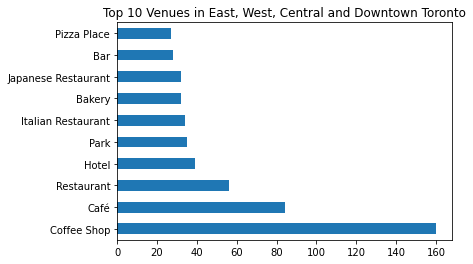

In [208]:
# The first ten venues
toronto_venues['Venue Category'].value_counts()[0:10].plot(kind='barh')
plt.title("Top 10 Venues in East, West, Central and Downtown Toronto")
plt.show()

There seems to have a lot of Coffe shops, Café and restaurants in EWCD toronto!

What about the Neighborhoods with most venues?

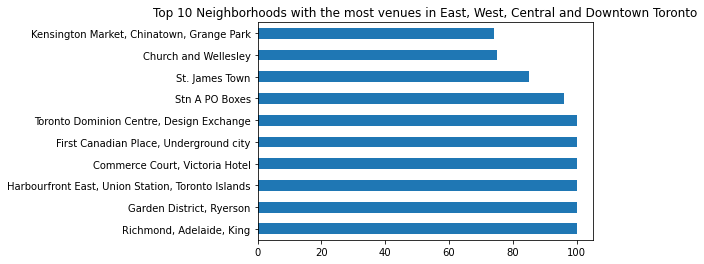

In [95]:
toronto_venues['Neighborhood'].value_counts()[0:10].plot(kind='barh')
plt.title("Top 10 Neighborhoods with the most venues in East, West, Central and Downtown Toronto")
plt.show()

In [100]:
top10_neighborhood = toronto_venues['Neighborhood'].value_counts()[0:10].index
top10_neighborhood

Index(['Richmond, Adelaide, King', 'Garden District, Ryerson',
       'Harbourfront East, Union Station, Toronto Islands',
       'Commerce Court, Victoria Hotel',
       'First Canadian Place, Underground city',
       'Toronto Dominion Centre, Design Exchange', 'Stn A PO Boxes',
       'St. James Town', 'Church and Wellesley',
       'Kensington Market, Chinatown, Grange Park'],
      dtype='object')

Let know a bit more about the top 3 neighborhoods:

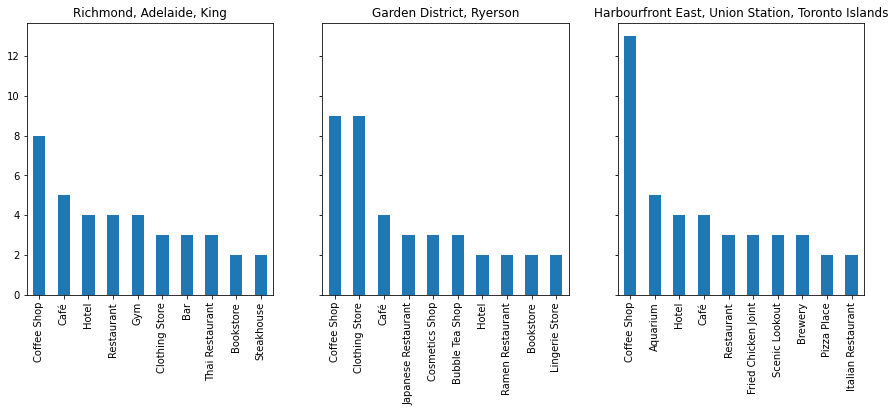

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
toronto_venues.loc[toronto_venues['Neighborhood']==top10_neighborhood[0], 'Venue Category'].value_counts()[0:10].plot(kind='bar', ax=axes[0])
axes[0].set_title(top10_neighborhood[0])
#
toronto_venues.loc[toronto_venues['Neighborhood']==top10_neighborhood[1], 'Venue Category'].value_counts()[0:10].plot(kind='bar', ax=axes[1])
axes[1].set_title(top10_neighborhood[1])
#
toronto_venues.loc[toronto_venues['Neighborhood']==top10_neighborhood[2], 'Venue Category'].value_counts()[0:10].plot(kind='bar', ax=axes[2])
axes[2].set_title(top10_neighborhood[2])
#
plt.show()

The Venues categories could be different according to the neighborhood. We can see that there is a Bookstore among the top 10 venues in Garden District and Richmond but not in Harbourfront!

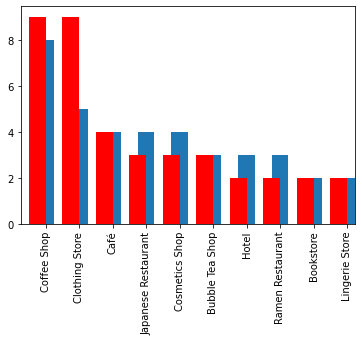

In [129]:
x = np.arange(10)  # the label locations
width = 0.35  # the width of the bars

fig, axes = plt.subplots()

toronto_venues.loc[toronto_venues['Neighborhood']==top10_neighborhood[0], 'Venue Category'].value_counts()[0:10].plot(kind='bar', ax=axes)
#
toronto_venues.loc[toronto_venues['Neighborhood']==top10_neighborhood[1], 'Venue Category'].value_counts()[0:10].plot(kind='bar', color = 'red', ax = axes, position=1.)
plt.show()

## 4. Categories Merging

In [235]:
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.654260,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
...,...,...,...,...,...,...,...
1619,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,TTC Russell Division,43.664908,-79.322560,Light Rail Station
1620,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Jonathan Ashbridge Park,43.664702,-79.319898,Park
1621,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Olliffe On Queen,43.664503,-79.324768,Butcher
1622,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,ONE Academy,43.662253,-79.326911,Gym / Fitness Center


In [269]:
dup_venues_cat = toronto_venues.loc[toronto_venues["Venue Category"] == 'Neighborhood', 'Venue Category']
dup_venues_cat.index

Int64Index([265, 415, 518, 958], dtype='int64')

Seems like there are 'Neighborhood' values in the column 'Venue Category'.

In [264]:
toronto_venues.loc[toronto_venues["Venue Category"] == 'Neighborhood']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
265,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
415,"Richmond, Adelaide, King",43.650571,-79.384568,Downtown Toronto,43.653232,-79.385296,Neighborhood
518,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Harbourfront,43.639526,-79.380688,Neighborhood
958,Studio District,43.659526,-79.340923,Leslieville,43.662070,-79.337856,Neighborhood


Let's rename them Neighborhoog_shop (Whatever the shop is)

In [282]:
for i in list(dup_venues_cat.keys()):
    toronto_venues.loc[i, 'Venue Category'] = 'Neighborhood_shop'
#
toronto_venues.iloc[index_dup, : ]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
265,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood_shop
415,"Richmond, Adelaide, King",43.650571,-79.384568,Downtown Toronto,43.653232,-79.385296,Neighborhood_shop
518,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Harbourfront,43.639526,-79.380688,Neighborhood_shop
958,Studio District,43.659526,-79.340923,Leslieville,43.662070,-79.337856,Neighborhood_shop


Let's now onehot-encoding the venue categories

In [283]:
# one hot encoding: Creating the dummie Data Frame
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Viewing the newly created Data Frame
print('the shape one toronto_onehot is {}'.format(toronto_onehot.shape))
toronto_onehot.head()

the shape one toronto_onehot is (1624, 236)


,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [285]:
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# Reorder the columns moving neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [286]:
# Shape of the data frame
print('the shape one toronto_onehot is {}'.format(toronto_onehot.shape))

the shape one toronto_onehot is (1624, 237)


Let's group the neighborhood:

In [287]:
# Let's group the neighborhood and apply the mean
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.00,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Central Bay Street,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.014706,0.000000,0.000000,0.014706,0.00,0.014706
5,Christie,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Church and Wellesley,0.013333,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.013333,0.000000,...,0.013333,0.000000,0.000000,0.00,0.000000,0.000000,0.013333,0.000000,0.00,0.026667
7,"Commerce Court, Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.00,0.000000
8,Davisville,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Davisville North,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000


Now let's create the new dataframe and display the top 10 venues for each neighborhood on the following way:
1. Firstly use a category reorder function
2. Secondly creating the data frame to store the result

In [303]:
# 1: Reorder function
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# 2: Data Frame creation
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Seafood Restaurant,Cocktail Bar,Farmers Market,Beer Bar,Restaurant,Cheese Shop,Bakery,Sandwich Place,Department Store
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Climbing Gym,Burrito Place,Restaurant,Italian Restaurant,Intersection,Bar
2,"Business reply mail Processing Centre, South C...",Park,Pizza Place,Light Rail Station,Skate Park,Burrito Place,Farmers Market,Fast Food Restaurant,Butcher,Restaurant,Recording Studio
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Boutique,Harbor / Marina,Boat or Ferry,Rental Car Location,Bar,Plane,Coffee Shop,Sculpture Garden
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Bubble Tea Shop,Department Store,Burger Joint,Japanese Restaurant,Thai Restaurant


## 5. Categories Clustering

Let's cluster East, West, central and Downtown Toronto into 5 clusters. To do so, we will follow the following 3 steps:
1. Perform the cluster analysis with the kMean algorithm
2. Merge the deduced clusters with the sorted neighborhood venues dataframe (neighborhoods_venues_sorted)
3. Visualy display the clusters on the map

In [291]:
## 1: Cluster analysis

# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop(columns = 'Neighborhood')

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [304]:
## 2: Data Gathering

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = EWCD_toronto

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # 

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Park,Pub,Bakery,Theater,Breakfast Spot,Café,Electronics Store,Spa,Beer Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Yoga Studio,Diner,Restaurant,Portuguese Restaurant,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Hotel,Bookstore,Pizza Place,Middle Eastern Restaurant
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,Gastropub,American Restaurant,Farmers Market,Hotel,Japanese Restaurant
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Neighborhood_shop,Pub,Health Food Store,Trail,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant


In [308]:
toronto_merged['Cluster Labels'].unique()

array([2, 3, 0, 4, 1])

In [307]:
## 3: Visualize the clusters on a map:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
from matplotlib.colors import to_hex
from matplotlib import colors
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = [to_hex(i) for i in colors_array] # works as well!!


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Let's observe the cluster 2:

In [313]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, 
                   toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,2,Coffee Shop,Park,Pub,Bakery,Theater,Breakfast Spot,Café,Electronics Store,Spa,Beer Store
4,Downtown Toronto,2,Coffee Shop,Yoga Studio,Diner,Restaurant,Portuguese Restaurant,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop
9,Downtown Toronto,2,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Hotel,Bookstore,Pizza Place,Middle Eastern Restaurant
15,Downtown Toronto,2,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,Gastropub,American Restaurant,Farmers Market,Hotel,Japanese Restaurant
20,Downtown Toronto,2,Coffee Shop,Seafood Restaurant,Cocktail Bar,Farmers Market,Beer Bar,Restaurant,Cheese Shop,Bakery,Sandwich Place,Department Store
24,Downtown Toronto,2,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Bubble Tea Shop,Department Store,Burger Joint,Japanese Restaurant,Thai Restaurant
25,Downtown Toronto,2,Grocery Store,Café,Park,Candy Store,Italian Restaurant,Nightclub,Baby Store,Restaurant,Athletics & Sports,Coffee Shop
30,Downtown Toronto,2,Coffee Shop,Café,Hotel,Gym,Restaurant,Clothing Store,Thai Restaurant,Bar,Bookstore,Burrito Place
31,West Toronto,2,Pharmacy,Bakery,Park,Middle Eastern Restaurant,Bank,Bar,Café,Supermarket,Music Venue,Brewery
36,Downtown Toronto,2,Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Restaurant,Scenic Lookout,Brewery,Pizza Place,Park


In [316]:
toronto_merged_bis = toronto_grouped
toronto_merged_bis.insert(1, 'Cluster', kmeans.labels_)
toronto_merged_bis.head()

,Neighborhood,Cluster,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,2,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.000000,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",2,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",2,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",2,0.0,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,Central Bay Street,2,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.014706,0.0,0.0,0.014706,0.0,0.014706


In [352]:
# Short clusters description:

for k in toronto_merged['Cluster Labels'].unique():
    mean_list = toronto_merged_bis.loc[toronto_merged_bis['Cluster']==k, 
                                   toronto_merged_bis.columns[2:] ].describe().loc['mean'].tolist()
    Min = min(mean_list)
    Max = max(mean_list)

    print("min_mean, max_max = ({}, {}) for cluster {}".format(Min, Max, k))


min_mean, max_max = (0.0, 0.08769829484330639) for cluster 2
min_mean, max_max = (0.0, 0.25) for cluster 3
min_mean, max_max = (0.0, 0.3611111111111111) for cluster 0
min_mean, max_max = (0.0, 0.5) for cluster 4
min_mean, max_max = (0.0, 0.5) for cluster 1


___